# Betweenness Centrality

Betweenness centrality can be calculated for either nodes or edges. It is the sum of the fraction of all-pairs shortest paths that pass through either nodes or edges (depending on which you are running it on). The algorithm we use is from NetworkX, read more here: https://networkx.org/documentation/networkx-1.10/reference/generated/networkx.algorithms.centrality.betweenness_centrality.html

note: betweenness_centrality doesn't work for MultiDiGraph, see: https://github.com/networkx/networkx/issues/4270

also see: https://github.com/networkx/networkx/issues/3432

## Data Prep

This notebook expects to see an 'admin' folder and a 'data' folder in your working directory. Your admin AOI shapefiles go inside the admin folder. When you call the main function, make sure the city argument is a string tha matches the name of the admin AOI shapefile you want to process (without the '.shp' part). The outputs will be saved in the 'data' folder in a folder with the same city name as well.

In [1]:
import sys
import osmnx as ox
import networkx as nx
import matplotlib.cm as cm
import matplotlib.colors as colors
import pandas as pd
import datetime
import numpy as np
import geocoder
from shapely.ops import unary_union
import geopandas as gpd
from glob import glob
import os
import pylab as pl
import matplotlib.pyplot as plt
import math
import pickle
ox.config(log_console=True, use_cache=True)

/Users/tomgertin/opt/anaconda3/envs/geo_env/lib/python3.11/site-packages/osmnx/utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(


In [2]:
def get_time(t1, t2):
    
    diff = t2 - t1
    
    c = round(diff.total_seconds() / 60, 2)
    
    return c

In [3]:
def get_polygon(string):
    
    admin_folder = './admin'

    for file in os.listdir(admin_folder):
        if file.endswith(f"{string}.shp"):  
            print(file)

            print('attempt to read file')
            # 1. need to transform the input shp to correct prj
            boundary_poly = gpd.read_file(admin_folder + '/' + file).set_crs(epsg=4326, allow_override=True)
            print('print admin_file crs')
            print(boundary_poly.crs)

            if not boundary_poly.crs == 'epsg:4326':
              sys.exit('admin file crs is not 4326, provide an admin file with crs than 4326 and re-run')
    
    #adm = adm.to_crs(epsg=4326)
    pol = [i for i in boundary_poly.geometry]
    boundary_poly = unary_union(pol)
        
    # if boundary_poly not defined
    #else:
        #boundary_poly = -1
    
    return boundary_poly

In [4]:
def get_graph(place):
    string = place.split(',')[0]
    
    try:
        os.mkdir('data/{}'.format(string))
    except FileExistsError:
        pass
    
    print('Fetching graph data for {}'.format(place))
    
    poly = get_polygon(string)
    poly = poly.buffer(0)
    #if poly == -1:
        #print('poly not defined')
    #else:
    try:
        #G = nx.read_gpickle('data/{a}/{a}'.format(a=string))
        
        # for networkX ver 3
        with open('data/{a}/{a}'.format(a=string), 'rb') as f:
            G = pickle.load(f)
        
        val = 1
    except FileNotFoundError:
        print("no pickle file found, retrieving new graph via OSMNX")
        G = ox.graph_from_polygon(poly, network_type='drive')
        val = 0
        
        # not sure if projecting is needed
        # Project a shapely geometry from its current CRS to another.
        #If to_crs is None, project to the UTM CRS for the UTM zone in which the
        #geometry's centroid lies.
        #G = ox.project_graph(G)

    print('Writing graph file')
    
    if val != 1:
        #nx.write_gpickle(G, path='data/{a}/{a}'.format(a=string))
        
        # for networkX ver 3
        with open('data/{a}/{a}'.format(a=string), 'wb') as f:
            pickle.dump(G, f, pickle.HIGHEST_PROTOCOL)
    
    return G

In [5]:
def get_centrality_stats(place):
    import numpy as np
    
    string = place.split(',')[0]
    
    try:
        edges = gpd.read_file("data/{}/edges.shp".format(string))
        
        if 'edge_centr' in edges.columns:
            df = pd.DataFrame()
            df['edge_centr'] = edges.edge_centr.astype(float)
            df['edge_centr_avg'] = np.nansum(df.edge_centr.values)/len(df.edge_centr)
            df.to_csv("data/{a}/Extended_stats_{a}.csv".format(a=string))
    except FileNotFoundError:
        print("Edges file doesn't exist. Running edge_centrality function.")
        G = get_graph(G)
        extended_stats = ox.extended_stats(G, bc=True)
        dat = pd.DataFrame.from_dict(extended_stats)
        dat.to_csv('data/{a}/Extended_Stats_{b}.csv'.format(a=string, b=string))
    except Exception as e:
        print('Exception Occurred', e)

In [6]:
def get_centrality(place, centrality_type = "both"):
    # centrality_type can be either node, edge, or both
    
    t1 = datetime.datetime.now()
    
    string = place.split(',')[0]
    
    # download and project a street network
    
    G = get_graph(place)
    #G = ox.graph_from_place('Davao City, Philippines')
    #G = ox.graph_from_place(place, which_result=None)
    t2 = datetime.datetime.now()
    
    print('{} minutes elapsed!'.format(get_time(t1, t2)))
    
    G = nx.DiGraph(G)
    
    if centrality_type == "node" or centrality_type == "both": 
    
        print('Getting node centrality')
        node_centrality = nx.betweenness_centrality(G)

        t3 = datetime.datetime.now()
        print('{} minutes elapsed!'.format(get_time(t1, t3)))
        
        nx.set_node_attributes(G, node_centrality, 'node_centrality')
    
    if centrality_type == "edge" or centrality_type == "both": 
        print('Getting edge centrality')
        # edge closeness centrality: convert graph to a line graph so edges become nodes and vice versa
        edge_centrality = nx.edge_betweenness_centrality(G)

        t4 = datetime.datetime.now()
        print('{} minutes elapsed!'.format(get_time(t1, t4)))
    
        new_edge_centrality = {}

        for u,v in edge_centrality:
            #new_edge_centrality[(u,v,0)] = edge_centrality[u,v]
            new_edge_centrality[(u,v)] = edge_centrality[u,v]
            
        nx.set_edge_attributes(G, new_edge_centrality, 'edge_centrality')
    
    print('Saving output gdf')
    
    print('print string')
    print(string)
    
    G = nx.MultiDiGraph(G)
    
    if centrality_type == "node":
        ox.save_graph_shapefile(G, filepath='data/{}'.format(string))
    elif centrality_type == "edge":
        ox.save_graph_shapefile(G, filepath='data/{}'.format(string))
    else:
        ox.save_graph_shapefile(G, filepath='data/{}'.format(string))
    
    t5 = datetime.datetime.now()
    
    print('{} minutes elapsed!'.format(get_time(t1, t5)))
    
    print('Getting basic stats')
    
    basic_stats = ox.basic_stats(G)
    dat = pd.DataFrame.from_dict(basic_stats)
    #dat.to_csv('data/{a}/Basic_Stats_{b}.csv'.format(a=string, b=string))
    dat.to_csv('data/{a}/Basic_Stats_{b}.csv'.format(a=string, b=string))
    
    t6 = datetime.datetime.now()
    
    print('{} minutes elapsed!'.format(get_time(t1, t6)))
    
    #print('Getting extended stats')
    
    #extended_stats = ox.extended_stats(G, bc=True)
    
    get_centrality_stats(string)
    
    #dat = pd.DataFrame.from_dict(extended_stats)
    #dat.to_csv('data/{a}/Extended_Stats_{b}.csv'.format(a=string, b=string))
    
    t7 = datetime.datetime.now()
    print('Completed with total time of {} minutes'.format(get_time(t1, t6)))
    
    return

In [7]:
def get_bc_graph_plots(place):
    
    string = place.split(',')[0]
    
    G = nx.read_gpickle("data/{a}/{b}".format(a=string, b=string))
    b = ox.basic_stats(G)
    
    #G_projected = ox.project_graph(G)
    node_lis = glob('data/{}/nodes.shp'.format(string))
    extended_path_lis = glob('data/{}/Extended_*.csv'.format(string))
    
    gdf_node = gpd.GeoDataFrame.from_file(node_lis[0])
    exten = pd.read_csv(extended_path_lis[0])
    exten= exten.rename(columns={'Unnamed: 0':'osmid'})
    exten['betweenness_centrality'] = exten['edge_centr']*100
    
    max_node = exten[exten.betweenness_centrality == max(exten.betweenness_centrality)]['osmid'].values[0]
    max_bc = max(exten.betweenness_centrality)
    
    nc = ['r' if node==max_node else '#336699' for node in G.nodes()]
    ns = [80 if node==max_node else 8 for node in G.nodes()]
    
    print('{}: The most critical node has {:.2f}% of shortest journeys passing through it. \n'.format(place, max_bc))
    print('The road network of {} has {} nodes and {} edges \n\n'.format(string, b['n'], b['m']))
    fig, ax =  ox.plot_graph(G, node_size=ns, node_color=nc, node_zorder=2, node_alpha=0.8, edge_alpha=0.8,
                            figsize=(8,8))
    gdf_node[gdf_node.osmid ==  max_node].plot(ax=ax, color='red', zorder = 3)
    
    #ax.set_title('{}: {:.2f}% of shortest paths between all nodes \n in the network through this node'.format(string, max_bc), fontsize=15)

    print('\n\n\n')
    
    fig.savefig('data/{}/{}_bc_graph_plot.png'.format(string, string), dpi=300)
    
    return

In [8]:
def get_network_plots(city):
    string = city.split(',')[0]
    
    G = get_graph(string)
    
    fig, ax = ox.plot_graph(G, bgcolor = '#ffffff', node_color = '#336699', node_zorder = 2, node_size = 5)
    
    fig.savefig('data/{}/{}_network_plot.png'.format(string, string), dpi=300)
    
    return 

In [9]:
def plot_radar(city):
    string = city.split(',')[0]
    print('print string')
    print(string)
    #G = ox.graph_from_place(city, network_type='drive')
    G = get_graph(city)
    
    try:
        if G.graph['crs'].is_projected:
            raise Exception("Graph seems to be projected, bearings will not generated if x and y are not in decimal degrees")
    except:
        print("graph seems to be unprojected, this is ok, continue")
        
    G = ox.add_edge_bearings(G)
    # return G
    
    # for debugging: gn.example_edge(G)
        
    #export edges with bearings
    #ox.io.save_graph_shapefile(G, filepath='data/{a}/shp_w_bearings'.format(a=string), encoding='utf-8')
    
    bearings = pd.Series([data.get('bearing', np.nan) for u, v, k, data in G.edges(keys=True, data=True)])
    # u = from node
    # v = to node
    # k = index for multiple edges between 2 nodes (0-indexed)
    # bearing = angle
    
    # save bearings as csv
    bearings.to_csv('data/{a}/{a}_bearings.csv'.format(a=string))
    
    fig = plt.figure()  # an empty figure with no axes
    ax = fig.add_subplot(1, 1, 1, projection='polar')

    polar_plot(ax, bearings)
    
    plt.show()
    
    fig.savefig('data/{a}/{a}_radar_plot.png'.format(a=string), dpi=300)
    plt.close() 
    
    return

In [10]:
def get_crp_cities_stats(cities):
    """
    Input:
    
    cities: list of cities
    
    Output:
    CSV file with CRP stats for cities provided as input
    """
    
    dat = pd.DataFrame(columns = ['Number of Intersections', 'Number of Roads', 'Total Length of network (in km)',
                             'Maximum Betweenness Centrality', 'Average Betweenness Centrality'])
    num_intersect, num_roads, tot_len, max_bw, avg_bw, city = [], [], [], [], [], []
    
    for i in cities:
        bas = pd.read_csv("data/{a}/Basic_Stats_{a}.csv".format(a=i))
        ext = pd.read_csv("data/{a}/Extended_stats_{a}.csv".format(a=i))
        num_intersect.append(bas['n'].unique()[0])
        num_roads.append(bas['m'].unique()[0])
        tot_len.append(float(bas.edge_length_total.unique()[0]) / 1000)
        max_bw.append(ext.betweenness_centrality.max())
        avg_bw.append(ext.betweenness_centrality_avg.iloc[0])
        city.append(i)

    dat['Number of Intersections'] = num_intersect
    dat['Number of Roads'] = num_roads
    dat['Total Length of network (in km)'] = tot_len
    dat['Maximum Betweenness Centrality'] = max_bw
    dat['Average Betweenness Centrality'] = avg_bw
    dat.index = city

    dat.to_csv('data/CRP_Stats.csv')

In [11]:
def count_and_merge(n, bearings):
    # make twice as many bins as desired, then merge them in pairs
    # prevents bin-edge effects around common values like 0° and 90°
    n = n * 2
    bins = np.arange(n + 1) * 360 / n
    count, _ = np.histogram(bearings, bins=bins)
    
    # move the last bin to the front, so that 0° to 5° and 355° to 360° will be binned together
    count = np.roll(count, 1)
    return count[::2] + count[1::2]

In [12]:
# function to draw a polar histogram for a set of edge bearings
# This function was adopted from an OSMNX example: https://github.com/gboeing/osmnx-examples/blob/9583920c08558662ef77d99529f13df757015172/notebooks/17-street-network-orientations.ipynb
def polar_plot(ax, bearings, n=36, title=''):

    bins = np.arange(n + 1) * 360 / n

    count = count_and_merge(n, bearings)
    _, division = np.histogram(bearings, bins=bins)
    frequency = count / count.sum()
    division = division[0:-1]
    width = 2 * np.pi / n
    
    #print('print division')
    #print(division)

    ax.set_theta_zero_location('N')
    ax.set_theta_direction('clockwise')

    x = division * np.pi / 180
    bars = ax.bar(x, height=frequency, width=width, align='center', bottom=0, zorder=2,
                  color='#003366', edgecolor='k', linewidth=0.5, alpha=0.7)
    
    ax.set_ylim(top=frequency.max())
    
    title_font = {'family':'DejaVu Sans', 'size':24, 'weight':'bold'}
    xtick_font = {'family':'DejaVu Sans', 'size':10, 'weight':'bold', 'alpha':1.0, 'zorder':3}
    ytick_font = {'family':'DejaVu Sans', 'size': 9, 'weight':'bold', 'alpha':0.2, 'zorder':3}
    
    ax.set_title(title.upper(), y=1.05, fontdict=title_font)
    
    ax.set_yticks(np.linspace(0, max(ax.get_ylim()), 5))
    yticklabels = ['{:.2f}'.format(y) for y in ax.get_yticks()]
    yticklabels[0] = ''
    ax.set_yticklabels(labels=yticklabels, fontdict=ytick_font)
    
    xticklabels = ['N', '', 'E', '', 'S', '', 'W', '']
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(labels=xticklabels, fontdict=xtick_font)
    ax.tick_params(axis='x', which='major', pad=-2)
    

In [13]:
def main(city, centrality_type="both"):
    
    # calculate either 'node' centrality, 'edge' centrality, or 'both'
    get_centrality(city, centrality_type = centrality_type)
    
    # may need to debug the betweeness centrality road network plots
    #get_bc_graph_plots(city)
    
    # plot the road network
    get_network_plots(city)
    
    # generate the road bearing polar plots
    plot_radar(city)
        
if __name__ == "__main__":
    if len(sys.argv) == 2:
        main(sys.argv[1])

In [14]:
import time
start = time.time()

In [15]:
AOI_name = 'Banjul_AOI'

Fetching graph data for Banjul_AOI
Banjul_AOI.shp
attempt to read file
print admin_file crs
EPSG:4326
no pickle file found, retrieving new graph via OSMNX
Writing graph file
0.18 minutes elapsed!
Getting edge centrality
18.75 minutes elapsed!
Saving output gdf
print string
Banjul_AOI


/Users/tomgertin/opt/anaconda3/envs/geo_env/lib/python3.11/site-packages/osmnx/io.py:87: UserWarning: The `save_graph_shapefile` function is deprecated and will be removed in a future release. Instead, use the `save_graph_geopackage` function to save graphs as GeoPackage files for subsequent GIS analysis.
  warnings.warn(
/Users/tomgertin/opt/anaconda3/envs/geo_env/lib/python3.11/site-packages/osmnx/io.py:114: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_nodes.to_file(filepath_nodes, driver="ESRI Shapefile", index=True, encoding=encoding)
/Users/tomgertin/opt/anaconda3/envs/geo_env/lib/python3.11/site-packages/osmnx/io.py:115: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_edges.to_file(filepath_edges, driver="ESRI Shapefile", index=True, encoding=encoding)


19.03 minutes elapsed!
Getting basic stats
19.26 minutes elapsed!
Completed with total time of 19.26 minutes
Fetching graph data for Banjul_AOI
Banjul_AOI.shp
attempt to read file
print admin_file crs
EPSG:4326
Writing graph file


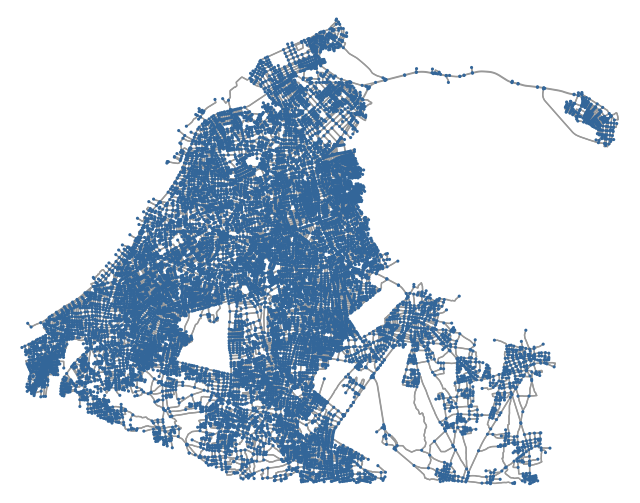

print string
Banjul_AOI
Fetching graph data for Banjul_AOI
Banjul_AOI.shp
attempt to read file
print admin_file crs
EPSG:4326
Writing graph file
graph seems to be unprojected, this is ok, continue


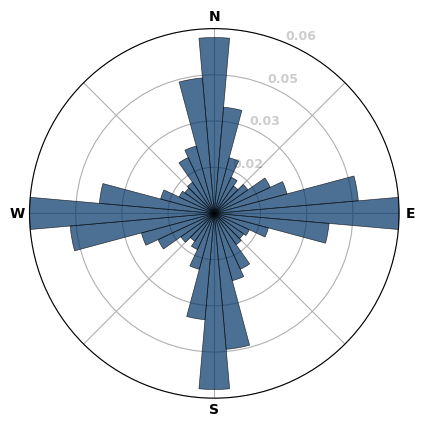

In [16]:
main(AOI_name, centrality_type = "edge")

In [17]:
end = time.time()
time_elapsed = end - start
time_elapsed

1164.31907081604

## Example of calling get_network_plus_building_footprints_plot

In [18]:
def get_network_plus_building_footprints_plot(place, zoom = 1, network_type='drive', bldg_color='orange', dpi=90,
              default_width=1, street_widths=None):
    
    # https://github.com/gboeing/osmnx-examples/blob/master/notebooks/10-building-footprints.ipynb
    # notes: The preview in Jupyter Notebook is only showing the roads, however the saved PNG file shows both the roads
    # and the building footprints
    
    string = place.split(',')[0]
    admin_folder = './admin'
    
    fp = f'data/{string}/{string}_network_plus_building_footprints.png'
    
    # Find centroid
    poly = gpd.read_file(admin_folder + '/' + string + '.shp').set_crs(epsg = 4326).geometry.buffer(0)
    centroid = poly.centroid
    x = centroid[0].coords.xy[0][0]
    y = centroid[0].coords.xy[1][0]
    
    # Find UTM
    utm_zone = math.floor((x + 180) / 6) + 1
    utm_crs = f"+proj=utm +zone={utm_zone} +ellps=WGS84 +datum=WGS84 +units=m +no_defs"
    
    # Find polygon length to set dist
    poly = poly.to_crs(crs = utm_crs)
    length = poly.length[0] / 2 / zoom
    print('distance:', length)

    gdf = ox.geometries.geometries_from_point((y, x), {'building':True}, dist = length)
    
    # figsize is in inches and can be adjusted to increase the size of the figure
    fig, ax = ox.plot_figure_ground(point=(y, x), figsize=(14, 14), dist=length, 
                                    network_type=network_type, 
                                    default_width=default_width,
                                    street_widths=street_widths, 
                                    save=False, show=True, close=True)
    
    fig, ax = ox.plot_footprints(gdf, ax=ax, filepath=fp, color=bldg_color, dpi=dpi, 
                                 save=True, show=True, close=True)

/var/folders/gr/04wfn6914nn08mfvwlf0_j2h0000gn/T/ipykernel_28425/316153714.py:15: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = poly.centroid


distance: 18414.526366303988


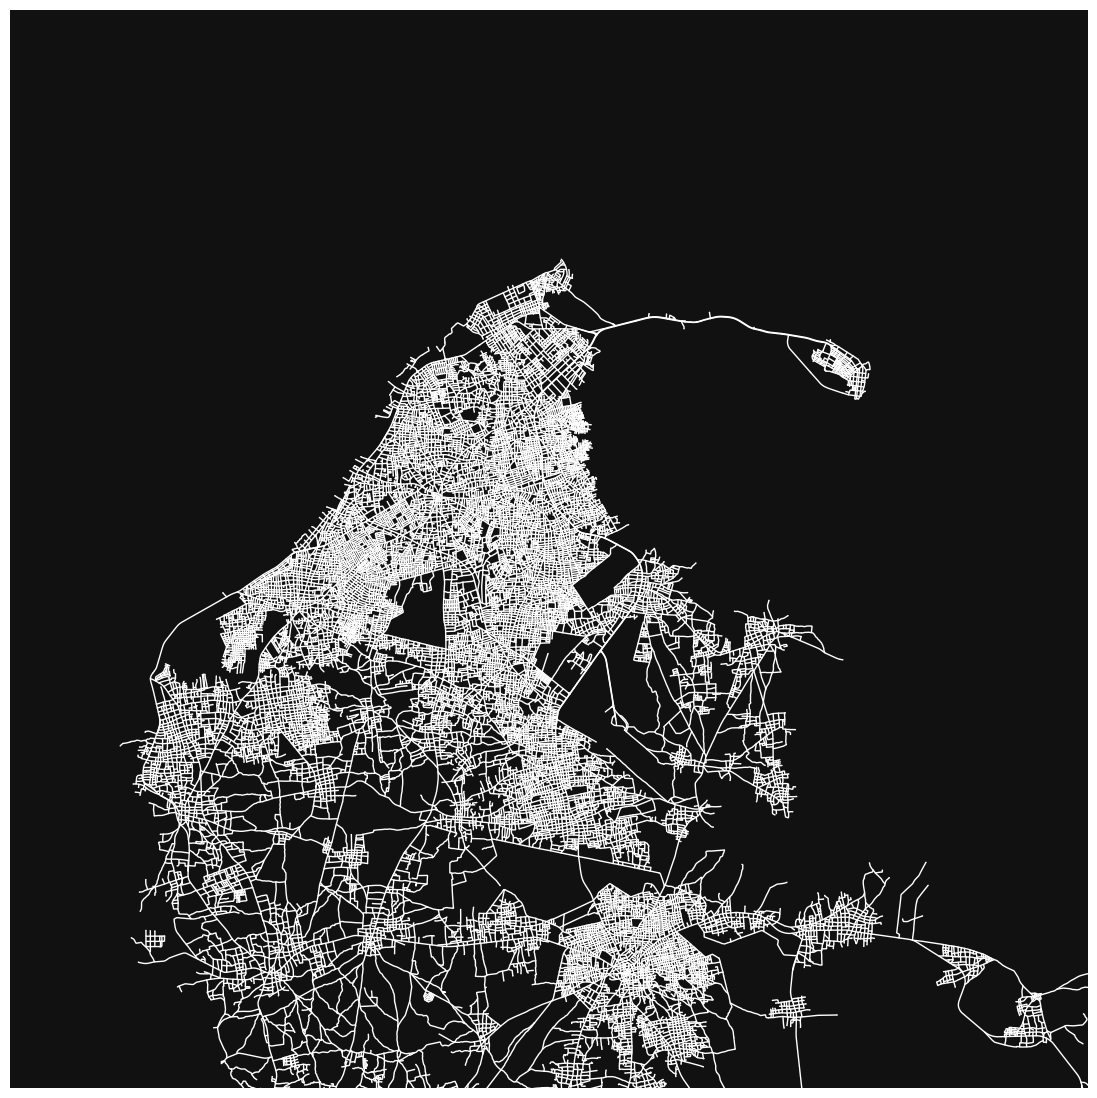

<Figure size 640x480 with 0 Axes>

In [19]:
# cover page
get_network_plus_building_footprints_plot(AOI_name,
                                          zoom = 4,
                                          network_type = 'drive', 
                                          bldg_color = 'orange', 
                                          dpi = 90,
                                          default_width = 1, 
                                          street_widths = {'secondary': 1, 'primary': 1})